In [18]:
import numpy as np
import matplotlib as mtlp
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import yaml
import pymc3 as pm
import math
import arviz as az
import theano
import theano.tensor as tensor
import pandas as pd
from matplotlib import rc
from scipy import optimize
import corner as crn
import seaborn as sns
import pickle 
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patches as mpl_patches
######
import sys
sys.path.append('../HelpherFunctions/')
from Chi2 import *
from Chi2Allvar import *
from mcmc import *
######
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams['font.family'] = 'serf'
filename ="../results/data.yaml"
########
stream = open(filename, 'r')#
data = yaml.safe_load(stream)
#
colpastil = ['#9cadce','#937eba','#f09494','#72bbd0','#52b2cf','#ffafcc','#d3ab9e' ]

In [19]:
#some constants 
NBINS = 100
LambdaNP2 = 1e+3**2
v4 = 246.**4
v3 = 246.**3
mh2 = 125.1**2
sqrt_2 = np.sqrt(2.0)
unity = lambda x : x


## Define Plotting functions for the posterior distributions

In [20]:
def makeplot(modelfile,filename, collider, label, limit,text1=r'Resummed $\lambda_3$',text2 ='',text3='',color= '#937eba',lambdas=[unity, unity]):
    """ Corner plot builder
    argument:
        trace: the trace from the pyMC3 run
        filename: the file to save the plot in
        collider: a string with the collider name to attach to the plot
    """
    colpastil = ['#f4ecec','#937eba','#72bbd0','#f09494','#91f0a1']
    with open(modelfile, 'rb') as buff:
        data = pickle.load(buff)
        model = data['model']
        trace = data['trace']
    var = ['C4Q', 'Cphi']
    samples = np.vstack((lambdas[0](trace['C4Q']), lambdas[1](trace['Cphi']))).T

    if lambdas[0] != unity:
        limit_t = np.array(limit)
        limit_t[0] = lambdas[0](limit[1])
        limit_t[1] = lambdas[0](limit[0])
        limit_t[2] = lambdas[1](limit[3])
        limit_t[3] = lambdas[1](limit[2])
        limits = limit_t
    else: limits = limit

    fig = plt.figure(1, figsize=(10, 10))

    fig = crn.corner(samples,labels = [label[0]+r'$[\mathrm{TeV}^{-2}]$', label[1]+r'$[\mathrm{TeV}^{-2}]$'], 
                     truths = None, bins=NBINS,
                     show_titles=True, title_kwargs={"fontsize": 22}, label_kwargs={"fontsize": 22},
                     levels=(1.-np.exp(-0.5), # 68 % CI 
                            1.-np.exp(-2.),  # 95% CI
                             #1.-np.exp(-4.5) # 99.7 CI
                            ),
                     plot_contours = True, fill_contours=True, smooth=True, smooth1d=None,
                     plot_datapoints = False, color=color, labelpad=-0.15, fig=fig, title_fmt='.3f', hist_kwargs={'linewidth': 2, 'histtype': 'bar'}, 
                     range=[(limits[0], limits[1]), (limits[2], limits[3])], truth_color='#343434')
    
    stats_func_1 = {
        'b0': lambda x: multimode(x, 0, 0.6827),
        'b1': lambda x: multimode(x, 1, 0.6827),
        }
    
    stats_func_2 = {
        'b0': lambda x: multimode(x, 0, 0.9545),
        'b1': lambda x: multimode(x, 1, 0.9545),
        }
    
 #   stats_func_3 = {
  #      'b0': lambda x: multimode(x, 0, 0.9973),
  #      'b1': lambda x: multimode(x, 1, 0.9973),
  #      }
    
    df_1 = pd.DataFrame(az.summary(trace, kind='stats', hdi_prob=0.6827, round_to='none', stat_funcs=stats_func_1))
    df_2 = pd.DataFrame(az.summary(trace, kind='stats', hdi_prob=0.9545, round_to='none', stat_funcs=stats_func_2))
 #   df_3 = pd.DataFrame(az.summary(trace, kind='stats', hdi_prob=0.9973, round_to='none', stat_funcs=stats_func_3))

    for ax in fig.get_axes():
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='y', which='both', direction='in')
        ax.tick_params(axis='x',  which='both',direction='in')
        ax.tick_params(axis='y', which='minor', top=True, size= 5)
        ax.tick_params(axis='x',  which='minor',right=True,size= 5)
        ax.tick_params(axis='y', which='major', labelsize=24, rotation=0,top=True,size=10 )
        ax.tick_params(axis='x',  which='major',labelsize=24, rotation=0,right=True,size=10 )


    
    ax = fig.get_axes()
    
    for j in range(2):
        for i in range(NBINS):
            
            lim_1l = min(lambdas[j](df_1.loc[var[j]]['b0']), lambdas[j](df_1.loc[var[j]]['b1']))
            lim_1u = max(lambdas[j](df_1.loc[var[j]]['b0']), lambdas[j](df_1.loc[var[j]]['b1']))
            
            lim_2l = min(lambdas[j](df_2.loc[var[j]]['b0']), lambdas[j](df_2.loc[var[j]]['b1']))
            lim_2u = max(lambdas[j](df_2.loc[var[j]]['b0']), lambdas[j](df_2.loc[var[j]]['b1']))
            
       #     lim_3l = min(lambdas[j](df_3.loc[var[j]]['b0']), lambdas[j](df_3.loc[var[j]]['b1']))
       #     lim_3u = max(lambdas[j](df_3.loc[var[j]]['b0']), lambdas[j](df_3.loc[var[j]]['b1']))
            
            if ax[3*j].patches[i].xy[0] > lim_1l and ax[3*j].patches[i].xy[0] < lim_1u:
                ax[3*j].patches[i].set_alpha(1)
            elif ax[3*j].patches[i].xy[0] > lim_2l and ax[3*j].patches[i].xy[0] < lim_2u:
                ax[3*j].patches[i].set_alpha(0.5)
     #       elif ax[3*j].patches[i].xy[0] > lim_3l and ax[3*j].patches[i].xy[0] < lim_3u:
      #          ax[3*j].patches[i].set_alpha(0.25)
            else:
                ax[3*j].patches[i].set_alpha(0.25)
    
    
    ## 1D histogram labels
    ax[0].set_title(label[0]+r'$ = [{:.3f}, {:.3f}]$'.format(lambdas[0](df_2.loc['C4Q']['hdi_2.275%']), lambdas[0](df_2.loc['C4Q']['hdi_97.725%'])), fontsize=22)
   # if 'lambda' in label[1]: ax[3].set_title(label[1]+r'$ = [{:.3f}, {:.3f}]$'.format(lambdas[1](df_2.loc['Cphi']['hdi_2.275%']), lambdas[1](df_2.loc['Cphi']['hdi_97.725%'])), fontsize=22)
    ax[3].set_title(label[1]+r'$ = [{:.3f}, {:.3f}]$'.format(lambdas[1](df_2.loc['Cphi']['hdi_2.275%']), lambdas[1](df_2.loc['Cphi']['hdi_97.725%'])), fontsize=22)
    
    ## title
    ax[1].annotate(collider, xy=(0.5, 0.7), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=28, fontweight='bold')
    ax[1].annotate(text1, xy=(0.5, 0.55), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=22)
    ax[1].annotate(text2, xy=(0.5, 0.45), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=22)
    ax[1].annotate(text3, xy=(0.5, 0.35), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=22)

    ax[2].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off)
      )
    ax[2].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off)
         ) 
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    


def plot2dist(modelfile1,modelfile2,filename, collider, label, limit,text,text1,text2):
    with open(modelfile1, 'rb') as buff:
        data1 = pickle.load(buff)
        model1 = data1['model']
        trace1 = data1['trace']
    
    with open(modelfile2, 'rb') as buff2:
        data2 = pickle.load(buff2)
        model2 = data2['model']
        trace2 = data2['trace']
    var = ['C4Q', 'Cphi']

    colpastil = ['#9cadce','#937eba','#f09494','#72bbd0', '#ffcaaf' ,'#ffafcc','#d3ab9e' ]
    fig, ax = plt.subplots(1, figsize=(8, 8))
    proxy = [plt.Rectangle((0,0),1,1,fc =colpastil[2+pc],alpha=0.5) 
    for pc in range(2)]

    plt.legend(proxy, [text1,text2],loc='best',fontsize= 26, frameon=True)
    colors = (250, 70, 50), (350, 70, 50)
    cmap = sns.blend_palette(colors, input="husl", as_cmap=True)
    #ax.set_prop_cycle(colpastil)
    az.plot_kde(
    trace1['C4Q'],
   values2= trace1['Cphi'],
   hdi_probs=[ 0.95],  # 1, 2 and 3 sigma contours
    contourf_kwargs={'alpha':0.5,'colors':colpastil[2]}
)
    az.plot_kde(
    trace2['C4Q'],
   values2= trace2['Cphi'],
   hdi_probs=[ 0.95],  # 1, 2 and 3 sigma contours
    contourf_kwargs={'alpha':0.5,'colors':colpastil[3]}
)
    for ax in fig.get_axes():
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='y', which='both', direction='in')
        ax.tick_params(axis='x',  which='both',direction='in')
        ax.tick_params(axis='y', which='minor', top=True, size= 5)
        ax.tick_params(axis='x',  which='minor',right=True,size= 5)
        ax.tick_params(axis='y', which='major', labelsize=26, rotation=0,top=True,size=10 )
        ax.tick_params(axis='x',  which='major',labelsize=26, rotation=0,right=True,size=10 )
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off)
      )
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off)
         ) 
    ax.set_xlabel(label[0]+r"$[\mathrm{TeV}^{-2}]$",fontsize= 28)
    ax.set_ylabel(label[1]+r"$[\mathrm{TeV}^{-2}]$",fontsize= 28)
    plt.text(-0.2,50,text,fontsize=24)
    plt.xlim(limits[0],limits[1])
    plt.ylim(limits[2],limits[3])
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

## Generate MCMC to obtain posterior distibutions 

In [4]:
Cqt1allHiggsLikelikhood = lambda c4q,ch : mylikelihood('Cqt8',c4q,ch,data,experiments=['ATLAS','CMS'],HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh'],TopChannels=None,linearl3=True,linearmu=True)
limits = [-5.5, 5.5, -60, 160]
config = [1500, 0.8, 50]
trace_dir='../results/fits/test.pickle'
model= runMCMC((Cqt1allHiggsLikelikhood), limits, config=config,trace_dir=trace_dir)


Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 1100
Interrupted at 1,099 [0%]: Average Loss = 12.827
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [Cphi, C4Q]


Sampling 50 chains for 1_000 tune and 1_500 draw iterations (50_000 + 75_000 draws total) took 47 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


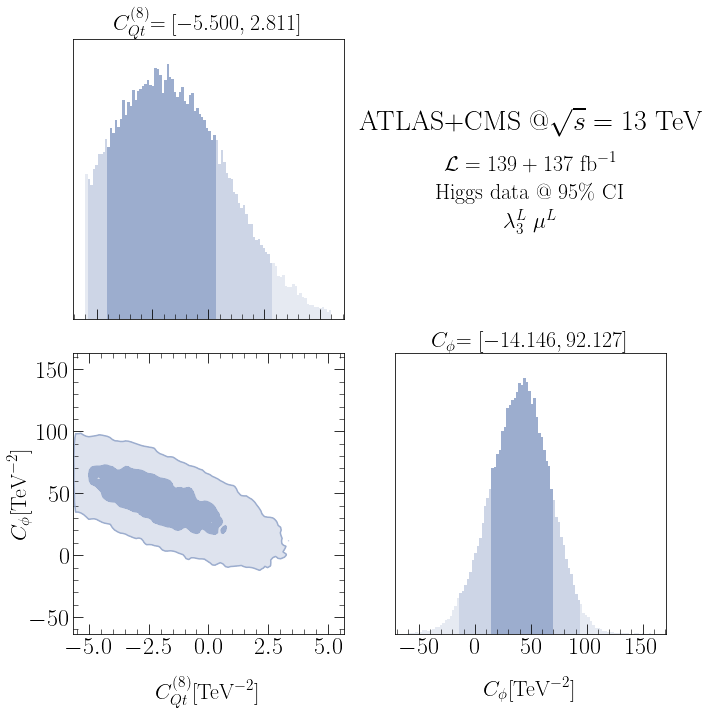

In [5]:
filename = '../results/plots/test.pdf'
makeplot(trace_dir, filename,color= colpastil[0],
         collider='ATLAS+CMS @$\sqrt{s}=13$ TeV',
         label=[r"$C_{Qt}^{(8)}$", r"$C_\phi$"], 
         text3=r'$\lambda_3^{L}\,\, \mu^{L}$ ',
         text2 =r'Higgs data @ 95\% CI',
         text1=r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',limit=limits)

#### We have 2 schema for the signal strength  $\mu^{L}:=1+\delta \sigma+\delta\Gamma-\delta \Gamma_h$ and $\mu^{R}:=(1+\delta \sigma)(\frac{1+\delta\Gamma}{1+\delta \Gamma_h})$
#### Also for the trilinear coupling scheme $\Sigma_{\lambda_3}=-2\frac{C_{\phi}v^2}{\Lambda^2 m_h^2}C_1 + \left(-4\frac{C_{\phi}v^4}{\Lambda^2 m_h^2}+4\frac{C_{\phi}^2 v^8}{m_h^2\Lambda^4}\right) C_2 \;\;\;\;\; (\lambda_3^{R}\,\text{scheme})$
#### und $\Sigma_{\lambda_3} = -2 \frac{C_\phi v^2}{\Lambda^2 m_h^2} C_1- 4 \frac{C_\phi v^4 \delta Z_h}{\Lambda^2 m_h^2} + \mathcal{O}\left( \frac{1}{\Lambda^4}\right) \;\;\;\;\; (\lambda_3^{L})$

## Make corner plots between 4F and $C_{\phi}$ operators with 95% credible intervals 

 $C_{Qt}^{(1)}$  VS $C_{\phi}$

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


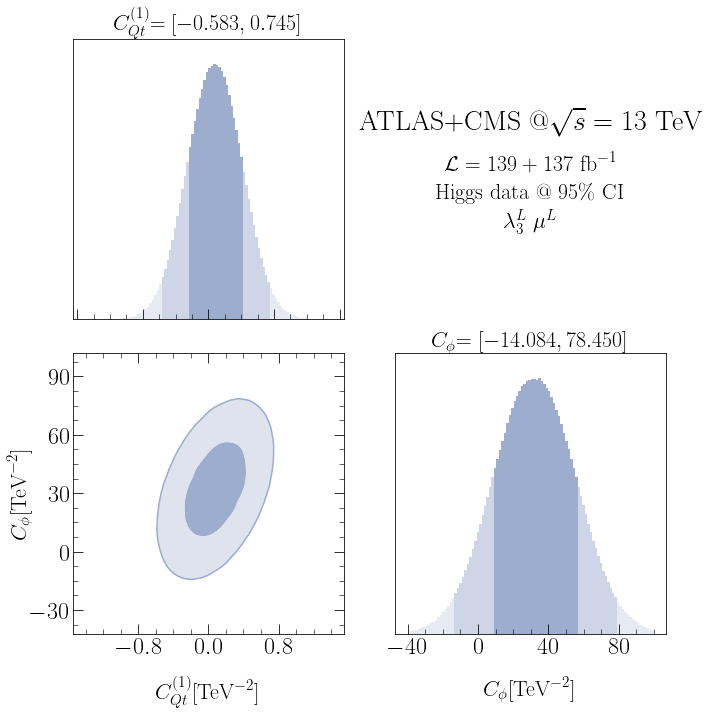

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


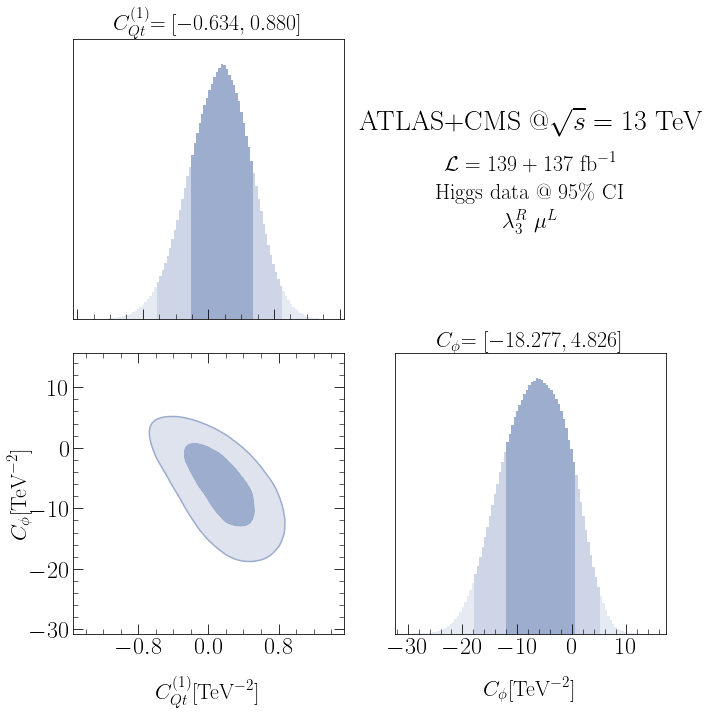

In [6]:
trace_dir='../results/fits/Cq1_AllHiggsObs_linearl3_linearmu.pickle'
limits = [-1.5, 1.5, -40, 100]
filename = '../results/plots/Cqt1_AllHiggsObs.pdf'
makeplot(trace_dir, filename,color= colpastil[0],
         collider='ATLAS+CMS @$\sqrt{s}=13$ TeV',
         label=[r"$C_{Qt}^{(1)}$", r"$C_\phi$"], 
         text3=r'$\lambda_3^{L}\,\, \mu^{L}$ ',
         text2 =r'Higgs data @ 95\% CI',
         text1=r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',limit=limits)
#
trace_dir='../results/fits/Cq1_AllHiggsObs_linearmu.pickle'
limits = [-1.5, 1.5, -30, 15]
filename = '../results/plots/Cqt1_AllHiggsObs_rl3.pdf'
makeplot(trace_dir, filename,color= colpastil[0],
         collider='ATLAS+CMS @$\sqrt{s}=13$ TeV',
         label=[r"$C_{Qt}^{(1)}$", r"$C_\phi$"], 
         text3=r'$\lambda_3^{R}\,\, \mu^{L}$ ',
         text2 =r'Higgs data @ 95\% CI',
         text1=r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',limit=limits)

 $C_{Qt}^{(8)}$  VS $C_{\phi}$

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


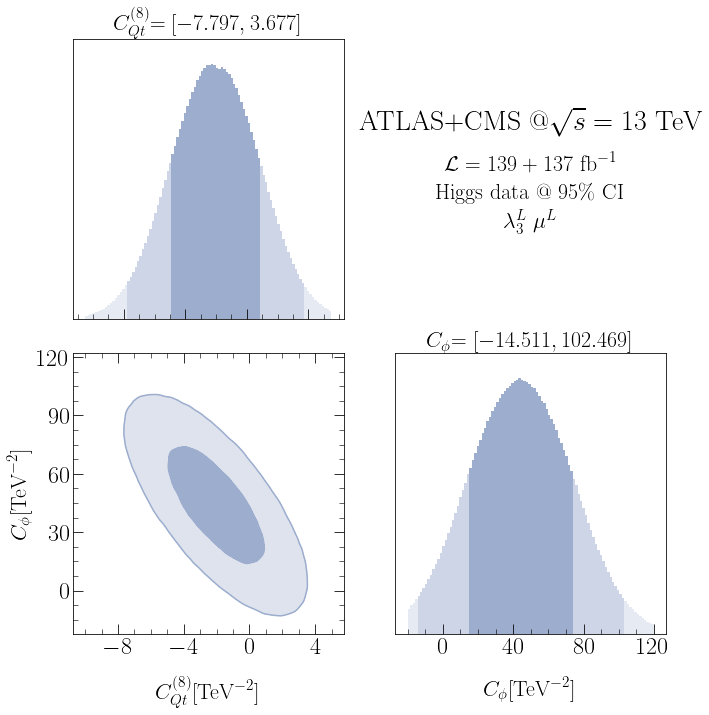

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


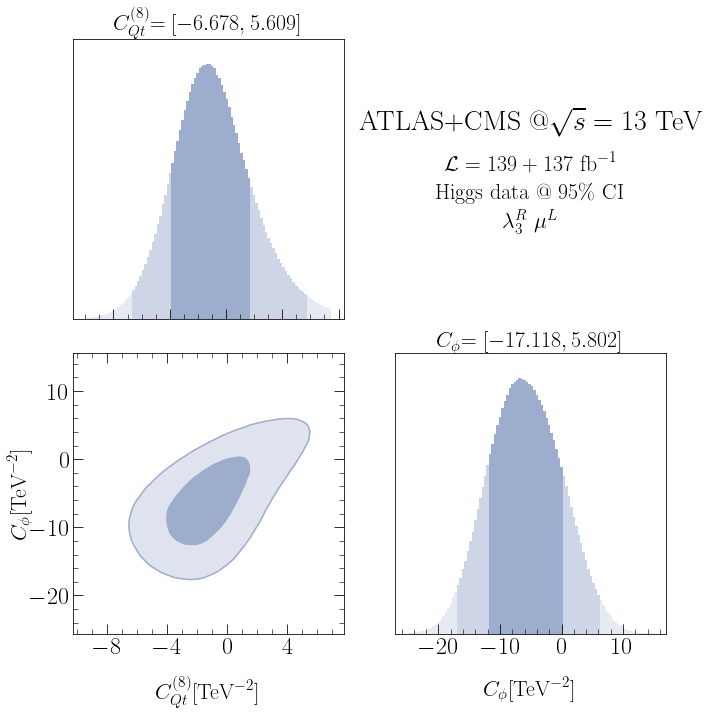

In [15]:
trace_dir='../results/fits/Cq8_AllHiggsObs_linearl3_linearmu.pickle'
limits = [-10.5, 5.5, -20, 120]
filename = '../results/plots/Cqt8_AllHiggsObs.pdf'
makeplot(trace_dir, filename,color= colpastil[0],
         collider='ATLAS+CMS @$\sqrt{s}=13$ TeV',
         label=[r"$C_{Qt}^{(8)}$", r"$C_\phi$"], 
         text3=r'$\lambda_3^{L}\,\, \mu^{L}$ ',
         text2 =r'Higgs data @ 95\% CI',
         text1=r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',limit=limits)
#
trace_dir='../results/fits/Cq8_AllHiggsObs_linearmu.pickle'
limits = [-10., 7.5, -25, 15]
filename = '../results/plots/Cqt8_AllHiggsObs_rl3.pdf'
makeplot(trace_dir, filename,color= colpastil[0],
         collider='ATLAS+CMS @$\sqrt{s}=13$ TeV',
         label=[r"$C_{Qt}^{(8)}$", r"$C_\phi$"], 
         text3=r'$\lambda_3^{R}\,\, \mu^{L}$ ',
         text2 =r'Higgs data @ 95\% CI',
         text1=r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',limit=limits)

 $C_{QtQb}^{(1)}$  VS $C_{\phi}$

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


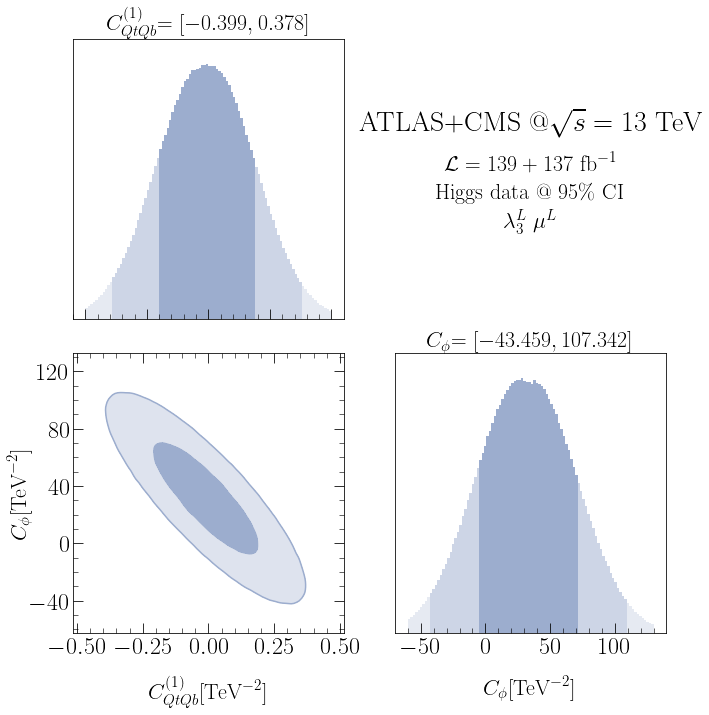

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


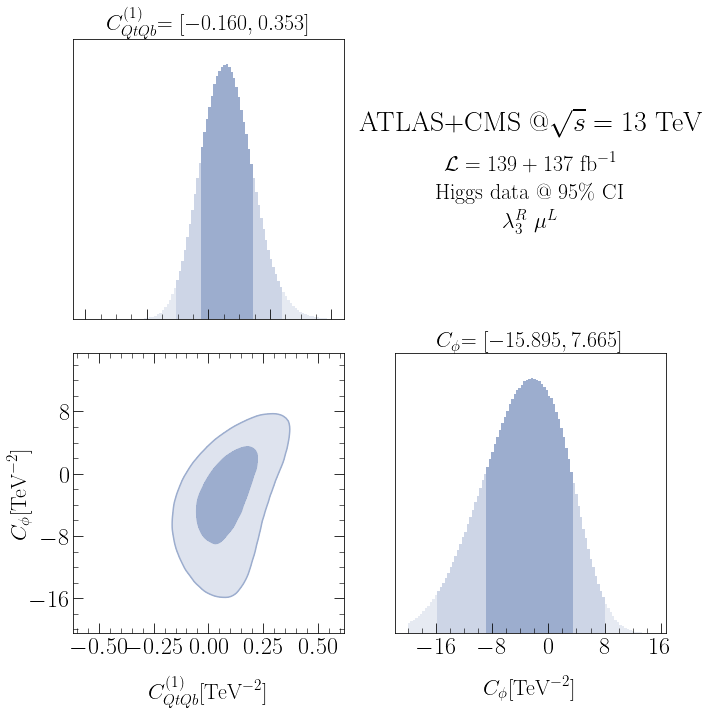

In [14]:
trace_dir='../results/fits/Cqtqb1_AllHiggsObs_linearl3_linearmu.pickle'
limits = [-.5, .5, -60, 130]
filename = '../results/plots/Cqtqb1_AllHiggsObs.pdf'
makeplot(trace_dir, filename,color= colpastil[0],
         collider='ATLAS+CMS @$\sqrt{s}=13$ TeV',
         label=[r"$C_{QtQb}^{(1)}$", r"$C_\phi$"], 
         text3=r'$\lambda_3^{L}\,\, \mu^{L}$ ',
         text2 =r'Higgs data @ 95\% CI',
         text1=r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',limit=limits)

trace_dir='../results/fits/Cqtqb1_AllHiggsObs_linearmu.pickle'
limits = [-.6, .6, -20, 15]
filename = '../results/plots/Cqtqb1_AllHiggsObs_rl3.pdf'
makeplot(trace_dir, filename,color= colpastil[0],
         collider='ATLAS+CMS @$\sqrt{s}=13$ TeV',
         label=[r"$C_{QtQb}^{(1)}$", r"$C_\phi$"], 
         text3=r'$\lambda_3^{R}\,\, \mu^{L}$ ',
         text2 =r'Higgs data @ 95\% CI',
         text1=r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',limit=limits)

 $C_{QtQb}^{(8)}$  VS $C_{\phi}$

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


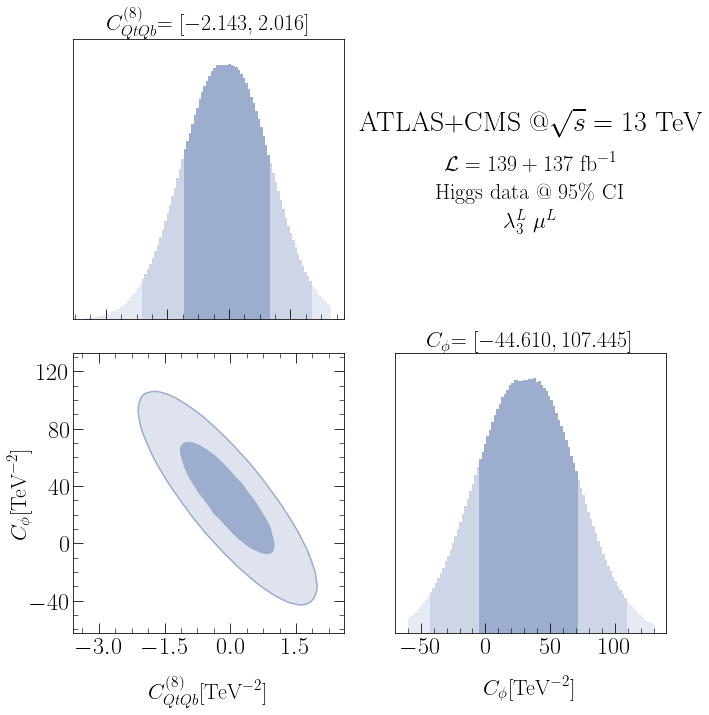

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


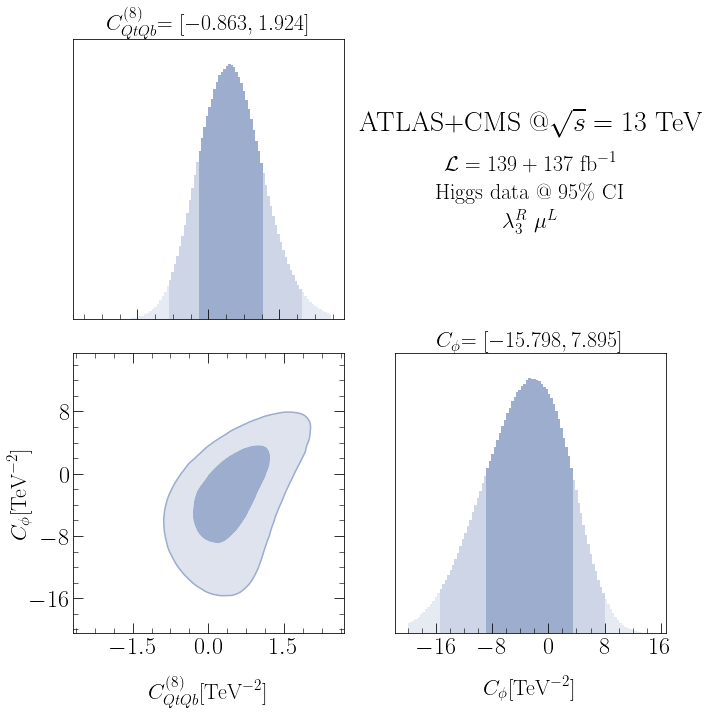

In [13]:
trace_dir='../results/fits/Cqtqb8_AllHiggsObs_linearl3_linearmu.pickle'
limits = [-3.5,2.5 , -60, 130]
filename = '../results/plots/Cqtqb8_AllHiggsObs.pdf'
makeplot(trace_dir, filename,color= colpastil[0],
         collider='ATLAS+CMS @$\sqrt{s}=13$ TeV',
         label=[r"$C_{QtQb}^{(8)}$", r"$C_\phi$"], 
         text3=r'$\lambda_3^{L}\,\, \mu^{L}$ ',
         text2 =r'Higgs data @ 95\% CI',
         text1=r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',limit=limits)

        
        #
trace_dir='../results/fits/Cqtqb8_AllHiggsObs_linearmu.pickle'
limits = [-2.6, 2.6, -20, 15]
filename = '../results/plots/Cqtqb8_AllHiggsObs_rl3.pdf'
makeplot(trace_dir, filename,color= colpastil[0],
         collider='ATLAS+CMS @$\sqrt{s}=13$ TeV',
         label=[r"$C_{QtQb}^{(8)}$", r"$C_\phi$"], 
         text3=r'$\lambda_3^{R}\,\, \mu^{L}$ ',
         text2 =r'Higgs data @ 95\% CI',
         text1=r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',limit=limits)

## Comparision between linear trilinear coupling $\lambda_3^{L}$ VS resummed signal strengths

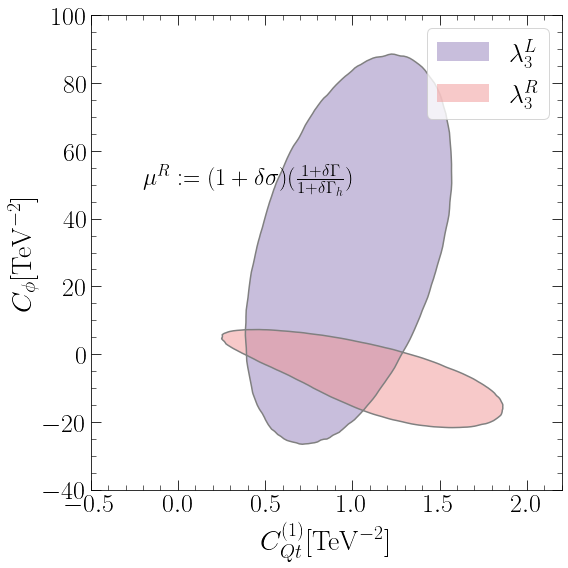

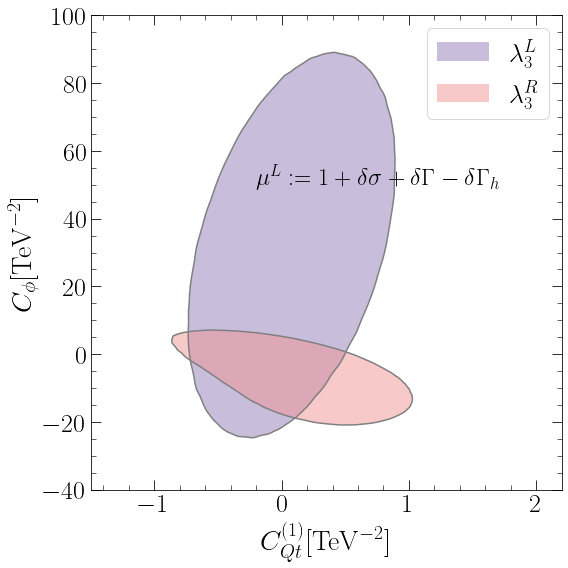

In [16]:
trace_dir1='../results/fits/Cq1_AllHiggsObs_linearl3.pickle'
trace_dir2='../results/fits/Cq1_AllHiggsObs.pickle'

limits = [-.5, 2.2, -40, 100]
filename = '../results/plots/vergleich_cqt1_muR.pdf'
plot2dist(trace_dir1,trace_dir2,filename, collider='ATLAS+CMS Run II', label=[r"$C_{Qt}^{(1)}$", r"$C_\phi$"],\
          text =r'$\mu^{R}:=(1+\delta \sigma)(\frac{1+\delta\Gamma}{1+\delta \Gamma_h})$',\
          text1=r'$\lambda_3^{L}$ ' , text2=r'$\lambda_3^{R}$ ',\
          limit=limits)

trace_dir1='../results/fits/Cq1_AllHiggsObs_linearl3_linearmu.pickle'
trace_dir2='../results/fits/Cq1_AllHiggsObs_linearmu.pickle'

limits = [-1.5, 2.2, -40, 100]
filename = '../results/plots/vergleich_cqt1_muL.pdf'
plot2dist(trace_dir1,trace_dir2,filename, collider='ATLAS+CMS Run II', label=[r"$C_{Qt}^{(1)}$", r"$C_\phi$"],\
          text =r"$\mu^{L}:=1+\delta \sigma+\delta\Gamma-\delta \Gamma_h$",\
          text1=r'$\lambda_3^{L}$ ' , text2=r'$\lambda_3^{R}$ ',\
          limit=limits)

### Summary Plots 

In [37]:
## from cycler import cycler
LambdaNP=1e+3  #GeV
v= 246.
mh=125.1

def CHtokl(CH):
    return 1-2.0*CH*v**4/mh**2/LambdaNP**2

def kltoCH(kl):
    return LambdaNP**2/v**4*mh**2*0.5*(1-kl)
def plotsummery(modelfiles,filename,labels,types,r,dat=data):
    stats_func_2 = {
        'b0': lambda x: multimode(x, 0, 0.9545),
        'b1': lambda x: multimode(x, 1, 0.9545),
        }
    
    ymu=np.zeros(1)
    yup=np.zeros(1)
    ydown=np.zeros(1)
    chmu=np.zeros(1)
    chup=np.zeros(1)
    chdown=np.zeros(1)
    #r=len(modelfiles)/len(labels) 
    x=np.arange(1/(r+2), len(modelfiles)+6/(r+2),1/(r+2)) # 6 is for the 4 top fit alone
    xch=np.arange(1/(r), len(modelfiles)+1/(r+1),1/(r)) # 6 is for the 4 top fit alone
    for modelfile in modelfiles:
        with open(modelfile, 'rb') as buff:
            data = pickle.load(buff)
            model = data['model']
            trace = data['trace']
            df_2 = pd.DataFrame(az.summary(trace, kind='stats', hdi_prob=0.9545, round_to='none', stat_funcs=stats_func_2))
            yup=np.append(yup,[df_2.loc['C4Q']['hdi_97.725%']])
            ymu=np.append(ymu,[df_2.loc['C4Q']['mean']])
            ydown=np.append(ydown,[df_2.loc['C4Q']['hdi_2.275%']])
            ##
            chup=np.append(chup,[df_2.loc['Cphi']['hdi_97.725%']])
            chmu=np.append(chmu,[df_2.loc['Cphi']['mean']])
            chdown=np.append(chdown,[df_2.loc['Cphi']['hdi_2.275%']])
            #print(df_2.loc['Cphi']['hdi_97.725%'])
            #print(df_2.loc['Cphi']['mean'])
            #print(df_2.loc['Cphi']['hdi_2.275%'])
            #print('------')
        

    
    yup= yup[yup!=0]
    ymu= ymu[ymu!=0]
    ydown= ydown[ydown!=0]
    chup= chup[chup!=0]
    chmu= chmu[chmu!=0]
    chdown= chdown[chdown!=0]
    # add 4 top data 
    ymu=np.insert(ymu,r,0)
    yup=np.insert(yup,r,dat['Bounds']['smeft_fit_quad']['Cqt1']+2*dat['Bounds']['smeft_fit_quad']['delta_Cqt1'])
    ydown=np.insert(ydown,r,dat['Bounds']['smeft_fit_quad']['delta_Cqt1'])
    ##
    ymu=np.insert(ymu,r+1,0)
    yup=np.insert(yup,r+1,dat['Bounds']['smeft_fit_linear']['Cqt1']+2*dat['Bounds']['smeft_fit_linear']['delta_Cqt1'])
    ydown=np.insert(ydown,r+1,dat['Bounds']['smeft_fit_linear']['delta_Cqt1'])
    #
    ymu=np.insert(ymu,2*(r+1),0)
    yup=np.insert(yup,2*(r+1),dat['Bounds']['smeft_fit_quad']['Cqt8']+2*dat['Bounds']['smeft_fit_quad']['delta_Cqt8'])
    ydown=np.insert(ydown,2*(r+1),dat['Bounds']['smeft_fit_quad']['delta_Cqt8'])
    #
    ymu=np.insert(ymu,2*(r+1)+1,0)
    yup=np.insert(yup,2*(r+1)+1,dat['Bounds']['smeft_fit_linear']['Cqt8']+2*dat['Bounds']['smeft_fit_linear']['delta_Cqt8'])
    ydown=np.insert(ydown,2*(r+1)+1,dat['Bounds']['smeft_fit_linear']['delta_Cqt8'])
    ##
    ymu=np.insert(ymu,3*(r+1)+1,0)
    yup=np.insert(yup,3*(r+1)+1,dat['Bounds']['smeft_fit_quad']['Cqtqb1']+2*dat['Bounds']['smeft_fit_quad']['delta_Cqtqb1'])
    ydown=np.insert(ydown,3*(r+1)+1,dat['Bounds']['smeft_fit_quad']['delta_Cqtqb1'])      
    ##
    ymu=np.insert(ymu,3*(r+1)+2,np.nan)
    yup=np.insert(yup,3*(r+1)+2,np.nan)
    ydown=np.insert(ydown,3*(r+1)+2,np.nan)  
    
    ymu=np.insert(ymu,4*(r+1)+2,0)
    yup=np.insert(yup,4*(r+1)+2,dat['Bounds']['smeft_fit_quad']['Cqtqb8']+2*dat['Bounds']['smeft_fit_quad']['delta_Cqtqb8'])
    ydown=np.insert(ydown,4*(r+1)+2,dat['Bounds']['smeft_fit_quad']['delta_Cqtqb8'])  
    ##
    ymu=np.insert(ymu,4*(r+1)+3,np.nan)
    yup=np.insert(yup,4*(r+1)+3,np.nan)
    ydown=np.insert(ydown,4*(r+1)+3,np.nan)  
    
    colpastil = ['#9cadce','#937eba','#f09494','#72bbd0', '#ffcaaf' ,'#ffafcc','#d3ab9e' ]
    fmts=['o','v','^','s','D','H','*']
    
    fig, ax = plt.subplots(1, figsize=(14, 6))
    r=r+2
    xl=0
   # labels.insert(-1,r"$C_{\phi}$")
    for i in range(len(modelfiles)+8):
        if i<r:
            plt.errorbar(x[i]-1/(r)/2,[ymu[i]],[[np.abs(ydown[i])+ymu[i]],[(yup[i])-ymu[i]]],fmt=fmts[int(i%r)],capsize=5,label=types[i],color=colpastil[int(i%r)])
        else:
            plt.errorbar(x[i]-1/(r)/2,[ymu[i]],[[np.abs(ydown[i])+ymu[i]],[(yup[i])-ymu[i]]],fmt=fmts[int(i%r)],capsize=5,color=colpastil[int(i%r)])
     #   print(x[i]-1/(r+2)/2)
        xl=x[i]
    for j in range(len(labels)):
        plt.axvline(j,color='k',lw=0.22)

        if j%2 ==0:
            ax.axvspan(j,j+1, alpha=0.1, color='gray')
    # plot CH
    
   # for j in range(r-2):
   #     plt.errorbar(xl+(j+1)/(r-1),chmu[j],-chmu[j]-chdown[j]+chup[j],fmt=fmts[j],capsize=5,color=colpastil[j])
        
   # plt.errorbar(xl+(r)/(r-1),kltoCH(-0.24),-kltoCH(-0.24)-kltoCH(17.0)+kltoCH(-9.4),fmt=fmts[r],capsize=5,color=colpastil[r],label='single param. fit')

    for ax in fig.get_axes():
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='y', which='both', direction='in')
        ax.tick_params(axis='x',  which='both',direction='in')
        ax.tick_params(axis='y', which='minor', top=True, size= 5)
        #ax.tick_params(axis='x',  which='minor',right=True,size= 5)
        ax.tick_params(axis='y', which='major', labelsize=26, rotation=0,top=True,size=10 )
        ax.tick_params(axis='x',  which='major',labelsize=26, rotation=0,right=True,size=0 )
        ax.set_xticks(np.arange(0.5, len(labels) + 0.5))
        ax.set_xticklabels(labels)
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off)
         ) 
    plt.xlim(xmin=0.0,xmax=xl)  
    plt.ylim(ymin=-15,ymax=10)
    #ax.set_xlabel(label[0]+r"$[\mathrm{TeV}^{-2}]$",fontsize= 28)
    ax.set_ylabel(r"95\% CI $ C\, [\mathrm{TeV}^{-2}]$",fontsize= 28)
    plt.legend(fontsize=20,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center',
           ncol=3, borderaxespad=0.,frameon=False)
    #plt.semilogy()
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    r=r-2
    fig2, ax2 = plt.subplots(1, figsize=(14, 6))
   # labels.insert(-1,r"$C_{\phi}$")
    for i in range(len(modelfiles)):
        ax2.text(xch[i]-1/(r)/2+0.01,50.0,r"$[{:2.2f},{:2.2f}]$".format(chdown[i],chup[i]),fontsize=10,rotation=60)
        if i<r:
            ax2.errorbar(xch[i]-1/(r)/2,[chmu[i]],[[np.abs(chdown[i])+chmu[i]],[(chup[i])-chmu[i]]],fmt=fmts[int(i%r)],capsize=5,label=types[i],color=colpastil[int(i%r)])
        else:
            ax2.errorbar(xch[i]-1/(r)/2,[chmu[i]],[[np.abs(chdown[i])+chmu[i]],[(chup[i])-chmu[i]]],fmt=fmts[int(i%r)],capsize=5,color=colpastil[int(i%r)])
     #   print(x[i]-1/(r+2)/2)
        xl=xch[i]
    for j in range(len(labels)):
        ax2.axvline(j,color='k',lw=0.22)

        if j%2 ==0:
            ax2.axvspan(j+1,j+2, alpha=0.1, color='gray')
    # plot CH
    ax2.axvline(len(labels)+1,color='k',lw=0.5)
   # for j in range(r-2):
   #     plt.errorbar(xl+(j+1)/(r-1),chmu[j],-chmu[j]-chdown[j]+chup[j],fmt=fmts[j],capsize=5,color=colpastil[j])
        
    for ax in fig.get_axes():
        ax2.yaxis.set_minor_locator(AutoMinorLocator())
        ax2.tick_params(axis='y', which='both', direction='in')
        ax2.tick_params(axis='x',  which='both',direction='in')
        ax2.tick_params(axis='y', which='minor', top=True, size= 5)
        #ax.tick_params(axis='x',  which='minor',right=True,size= 5)
        ax2.tick_params(axis='y', which='major', labelsize=24, rotation=0,top=True,size=10 )
        ax2.tick_params(axis='x',  which='major',labelsize=24, rotation=0,right=True,size=0 )
        ax2.set_xticks(np.arange(0.5, len(labels) + 0.5))
        ax2.set_xticklabels(labels)
    ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off)
         ) 
    plt.xlim(xmin=0.0,xmax=xl+(3)/(r)+1/(2*r))         
    plt.ylim(ymax=100)
    ax2.set_xlabel(r" fit for $C_\phi$ as a dyad with 4F $C_i$" ,fontsize= 24)
    ax2.set_ylabel(r"95\% CI $ C_\phi\, [\mathrm{TeV}^{-2}]$",fontsize= 24)
    ax2.legend(fontsize=18,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center',
           ncol=4, borderaxespad=0.,frameon=False)
    #plt.semilogy()
    plt.tight_layout()
    fig2.savefig('../results/plots/uebeblick_cphi.pdf', dpi=300, bbox_inches='tight')
    plt.show()

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got 

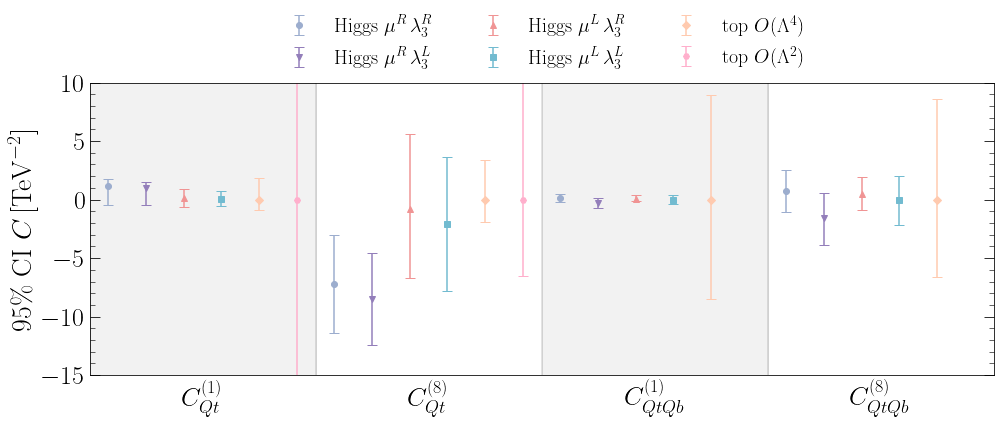

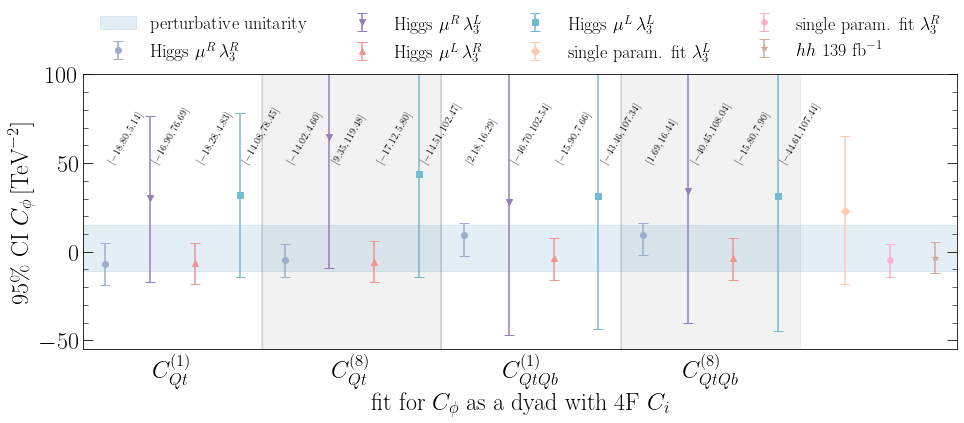

In [38]:
filename = '../results/plots/ueberblickplot.pdf'

files =['../results/fits/Cq1_AllHiggsObs.pickle',
        '../results/fits/Cq1_AllHiggsObs_linearl3.pickle',
        '../results/fits/Cq1_AllHiggsObs_linearmu.pickle',
        '../results/fits/Cq1_AllHiggsObs_linearl3_linearmu.pickle',
        '../results/fits/Cq8_AllHiggsObs.pickle',
        '../results/fits/Cq8_AllHiggsObs_linearl3.pickle',
        '../results/fits/Cq8_AllHiggsObs_linearmu.pickle',
        '../results/fits/Cq8_AllHiggsObs_linearl3_linearmu.pickle'
        ,
        '../results/fits/Cqtqb1_AllHiggsObs.pickle',
        '../results/fits/Cqtqb1_AllHiggsObs_linearl3.pickle',
        '../results/fits/Cqtqb1_AllHiggsObs_linearmu.pickle',
        '../results/fits/Cqtqb1_AllHiggsObs_linearl3_linearmu.pickle'
                ,
        '../results/fits/Cqtqb8_AllHiggsObs.pickle',
        '../results/fits/Cqtqb8_AllHiggsObs_linearl3.pickle',
        '../results/fits/Cqtqb8_AllHiggsObs_linearmu.pickle',
        '../results/fits/Cqtqb8_AllHiggsObs_linearl3_linearmu.pickle'
       ]
plotsummery(files,filename,labels=[r"$C_{Qt}^{(1)}$","$C_{Qt}^{(8)}$","$C_{QtQb}^{(1)}$","$C_{QtQb}^{(8)}$"],types=[r"Higgs $\mu^{R}\,\lambda_3^{R}$",
                                                             r"Higgs $\mu^{R}\,\lambda_3^{L}$",
                                                              r"Higgs $\mu^{L}\,\lambda_3^{R}$",
                                                             r"Higgs $\mu^{L}\,\lambda_3^{L}$",r"top $O(\Lambda^4)$",r"top $O(\Lambda^2)$"],r=4,dat=data)

## Fit with new variables

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 200
Interrupted at 199 [0%]: Average Loss = 13.88
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [Cphi, C4Q]


Sampling 50 chains for 30_000 tune and 150_000 draw iterations (1_500_000 + 7_500_000 draws total) took 2142 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


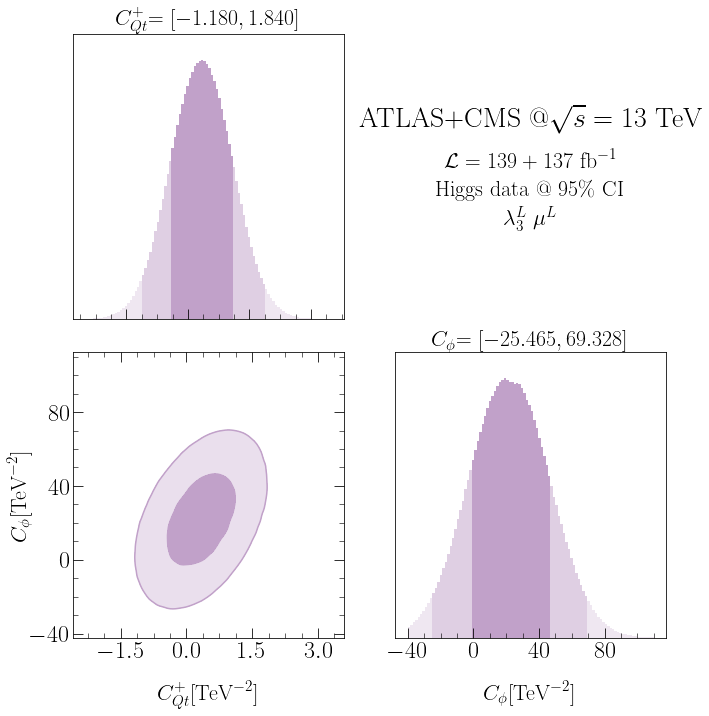

In [5]:
CF= 4/3
llCqtp =lambda Cqup,CH :mylikelihoodAV(Cqup/2,+1/CF/2*Cqup,0.0,0.0,CH,data,experiments=['CMS','ATLAS'],
                                                                           HiggsChannels=['ggf','ttxh','vbf','vh','zh','wh']
                                                                           ,TopChannels=None,
                                                                           linearl3=True,linearmu=True)
limits = [-2.5, 3.5, -40, 110]
config = [150000, 0.8, 50]
trace_dir='../results/fits/CQtp.pickle'
model= runMCMC(llCqtp, limits, config=config,trace_dir=trace_dir)
filename = '../results/plots/CQtp.pdf'
makeplot(trace_dir, filename,color= '#c1a1c9',
         collider='ATLAS+CMS @$\sqrt{s}=13$ TeV',
         label=[r"$C_{Qt}^{+}$", r"$C_\phi$"], 
         text3=r'$\lambda_3^{L}\,\, \mu^{L}$ ',
         text2 =r'Higgs data @ 95\% CI',
         text1=r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',limit=limits)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


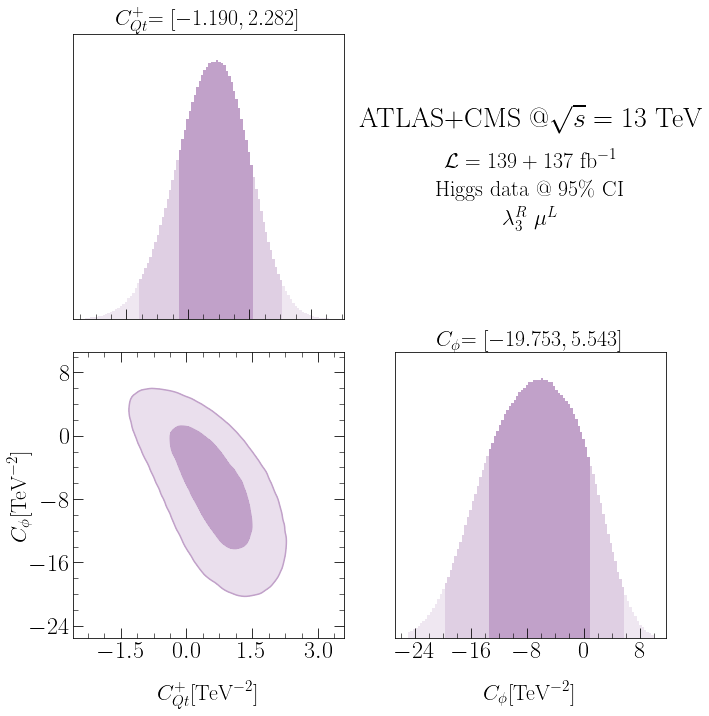

In [32]:
CF= 4/3
llCqtp =lambda Cqup,CH :mylikelihoodAV(Cqup/2,+1/CF/2*Cqup,0.0,0.0,CH,data,experiments=['CMS','ATLAS'],
                                                                           HiggsChannels=['ggf','ttxh','vbf','vh','zh','wh']
                                                                           ,TopChannels=None,
                                                                           linearl3=False,linearmu=True)
limits = [-2.5, 3.5, -25, 10]
config = [150000, 0.8, 50]
trace_dir='../results/fits/CQtp_lambda3R.pickle'
#model= runMCMC(llCqtp, limits, config=config,trace_dir=trace_dir)
filename = '../results/plots/CQtp_lambda3R.pdf'
makeplot(trace_dir, filename,color= '#c1a1c9',
         collider='ATLAS+CMS @$\sqrt{s}=13$ TeV',
         label=[r"$C_{Qt}^{+}$", r"$C_\phi$"], 
         text3=r'$\lambda_3^{R}\,\, \mu^{L}$ ',
         text2 =r'Higgs data @ 95\% CI',
         text1=r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',limit=limits)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


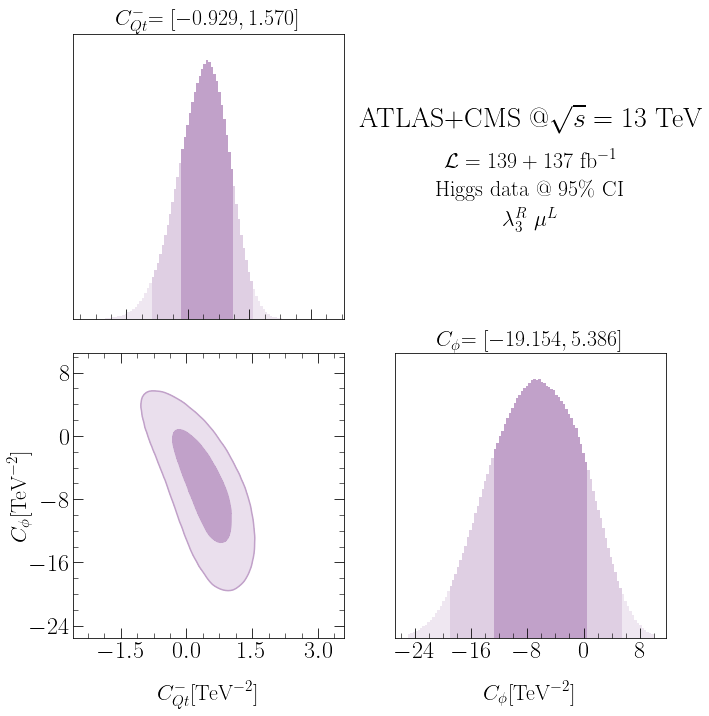

In [31]:
CF= 4/3
llCqtm =lambda Cqup,CH :mylikelihoodAV(Cqup/2,-1/CF/2*Cqup,0.0,0.0,CH,data,experiments=['CMS','ATLAS'],
                                                                           HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh']
                                                                           ,TopChannels=None,
                                                                           linearl3=False,linearmu=True)
limits = [-2.5, 3.5, -25, 10]
config = [150000, 0.8, 50]
trace_dir='../results/fits/CQtm_lambda3R.pickle'
#model= runMCMC(llCqtm, limits, config=config,trace_dir=trace_dir)
filename = '../results/plots/CQtm_lambda3R.pdf'
makeplot(trace_dir, filename,color= '#c1a1c9',
         collider='ATLAS+CMS @$\sqrt{s}=13$ TeV',
          label=[r"$C_{Qt}^{-}$", r"$C_\phi$"], 
         text3=r'$\lambda_3^{R}\,\, \mu^{L}$ ',
         text2 =r'Higgs data @ 95\% CI',
         text1=r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',limit=limits)

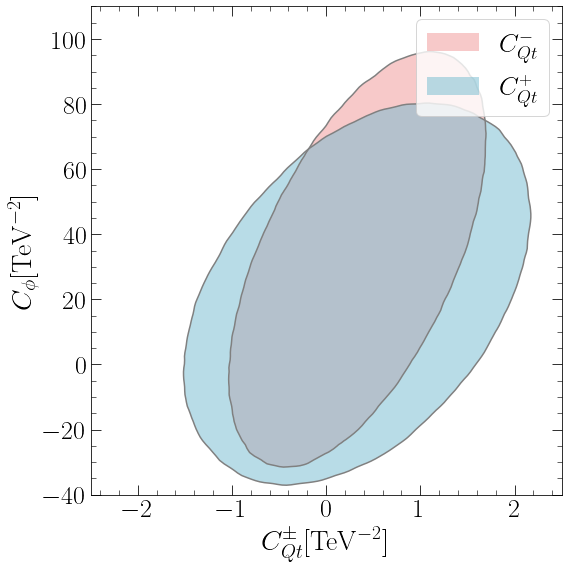

In [27]:
trace_dir1='../results/fits/CQtm.pickle'
trace_dir2='../results/fits/CQtp.pickle'

limits = [-2.5, 2.5, -40, 110]
filename = '../results/plots/vergleich_cqtmp_muL.pdf'
plot2dist(trace_dir1,trace_dir2,filename, collider='ATLAS+CMS Run II', label=[r"$C_{Qt}^{\pm}$", r"$C_\phi$"],\
          text =r"",\
          #text1=r'$C_{Qt}^{(1)}-C_{Qt}^{(8)}$ ' , text2=r'$C_{Qt}^{(1)}+C_{Qt}^{(8)}$',\
          text1=r"$C_{Qt}^{-}$" , text2=r"$C_{Qt}^{+}$",\
          limit=limits)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


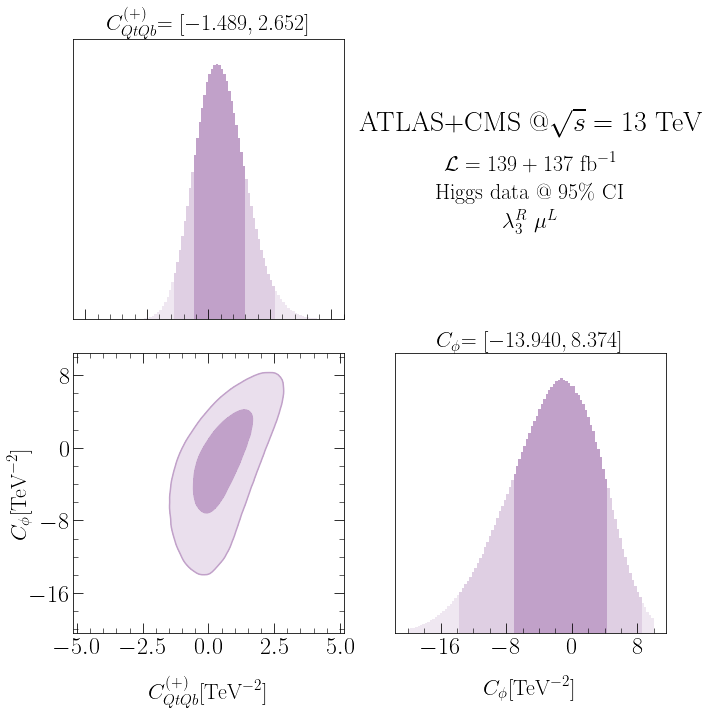

In [29]:
CF= 4/3
Nc=3
llCqtp =lambda Cqup,CH :mylikelihoodAV(0.0,0.0,1/2/(2*Nc+1)*Cqup,+1/CF*Cqup/2,CH,data,experiments=['CMS','ATLAS'],
                                                                           HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh']
                                                                           ,TopChannels=None,
                                                                           linearl3=False,linearmu=True)
limits = [-5., 5., -20, 10]
config = [150000, 0.8, 50]
trace_dir='../results/fits/CQtQbp_lambda3R.pickle'
#model= runMCMC(llCqtp, limits, config=config,trace_dir=trace_dir)
filename = '../results/plots/CQtQbp_lambda3R.pdf'
makeplot(trace_dir, filename,color= '#c1a1c9',
         collider='ATLAS+CMS @$\sqrt{s}=13$ TeV',
         label=[r"$C_{QtQb}^{(+)}$", r"$C_\phi$"], 
         text3=r'$\lambda_3^{R}\,\, \mu^{L}$ ',
         text2 =r'Higgs data @ 95\% CI',
         text1=r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',limit=limits)

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 8100
Interrupted at 8,099 [4%]: Average Loss = 22.839
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [Cphi, C4Q]


Sampling 50 chains for 3_000 tune and 15_000 draw iterations (150_000 + 750_000 draws total) took 226 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


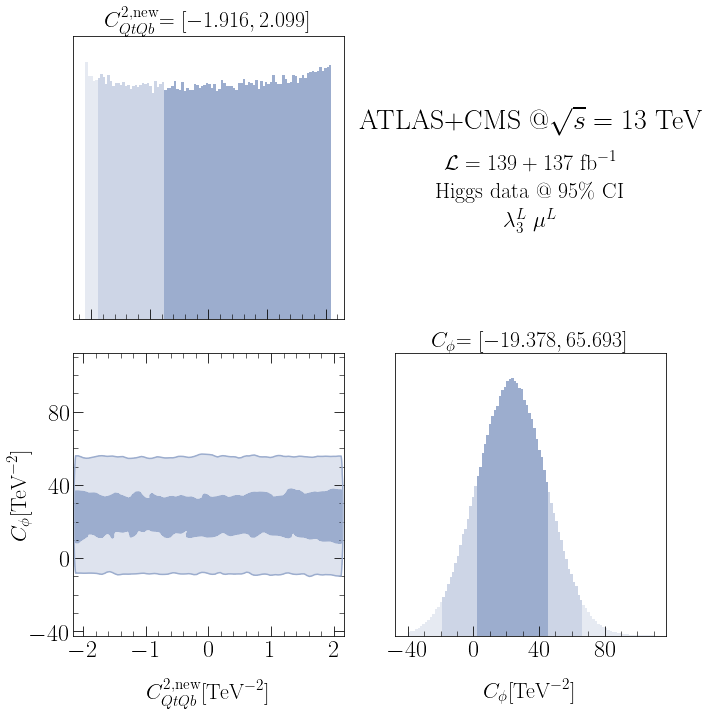

In [106]:
CF= 4/3
Nc=3
llCqtp =lambda Cqup,CH :mylikelihoodAV(0.0,0.0,1/(2*Nc+1)*Cqup/2,-1/CF*Cqup/2,CH,data,experiments=['CMS','ATLAS'],
                                                                           HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh']
                                                                           ,TopChannels=None,
                                                                           linearl3=True,linearmu=True)
limits = [-2.1, 2.1, -40, 110]
config = [15000, 0.8, 50]
trace_dir='../results/fits/CQtQbm.pickle'
model= runMCMC(llCqtp, limits, config=config,trace_dir=trace_dir)
filename = '../results/plots/CQtQbm.pdf'
makeplot(trace_dir, filename,color= colpastil[0],
         collider='ATLAS+CMS @$\sqrt{s}=13$ TeV',
         label=[r"$C_{QtQb}^{2,\mathrm{new}}$", r"$C_\phi$"], 
         text3=r'$\lambda_3^{L}\,\, \mu^{L}$ ',
         text2 =r'Higgs data @ 95\% CI',
         text1=r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',limit=limits)